In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from vis.utils import utils
from tensorflow.keras.optimizers import Optimizer, Adam,RMSprop, SGD

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib
import imutils
#import argparse
import os
import math
import cv2

In [4]:
# Class for the optimizer Itao ( a new Iterative thresholding algorithm based optimizer)
class Itao(Optimizer):
    def __init__(self, k=10.0, lamda=0.00001, name="Itao", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("k", k) # tuning hyperparameter K
        self._set_hyper("lamda", lamda) # Tikhonov parameter lamda
        
    

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        
        var_dtype = var.dtype.base_dtype
        k = self._get_hyper("k", var_dtype)
        lamda = self._get_hyper("lamda", var_dtype)
        new_var = (k/(k+lamda))*var - grad/(k+lamda) # update variables
        var.assign(new_var)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "k": self._serialize_hyperparameter(self._k),
            "lamda": self._serialize_hyperparameter(self._lamda),
            
        }
    def get_config(self):
        config = super(Itao, self).get_config()
        config.update({
            "k": self._serialize_hyperparameter("k"),
            "lamda": self._serialize_hyperparameter("lamda"),
            
        })
        return config

In [5]:
7%9

7

In [6]:
#utility function to show images
def display_imgs(images):
    subprot_args = {
     'nrows': 2,
     'ncols': 4,
     'figsize': (6, 3),
     'subplot_kw': {'xticks': [], 'yticks': []}
    }
    f, ax = plt.subplots(**subprot_args)
    for i in range(len(images)):
        ax[i//4, i%4].imshow(images[i])
    plt.tight_layout()
    plt.show()


In [7]:
model = load_model('covid19_models_cross_val_InceptionV3/model_InceptionV3_fold_2.h5', compile=False)
model.compile(loss="categorical_crossentropy", optimizer=Itao(), metrics=["acc"])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # Constructor of class to initialize model
        # index of class used to measure the class activation map
        # layer name used to visualize the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName


    def compute_heatmap(self, image):
        
        with tf.GradientTape() as tape:
            # Get the convolutional layer
            # Get de class output corresponding to the input image
            last_conv_layer = model.get_layer(self.layerName)
            iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
            model_out, last_conv_layer = iterate(image)
            class_out = model_out[:, np.argmax(model_out[0])]
        
        # We take the gradient of the output class with respect to the 
        # feature-maps of the convolutional layer chosen
        grads = tape.gradient(class_out, last_conv_layer)
        dim = grads.shape[2]
        # We compute the average of the gradient values, and use them 
        # to compute the ponderation of the filters. Then
        # we calculate the average per filter of the feature-map 
        # which gives us the heatmap of the activation class.
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

        # normalize the heatmap such that all values lie in the range
        # [0, 1]
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        #heatmap = heatmap.reshape((5, 5))
        heatmap = heatmap.reshape((dim, dim))
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
        #heatmap = cv2.applyColorMap(np.uint8(255 * (1 - heatmap)), cv2.COLORMAP_JET)

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        # apply the supplied color map to the heatmap and then
        heatmap = cv2.applyColorMap(np.uint8(255 * (1 - heatmap)), colormap)
        # overlay the heatmap on the input image
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)/255
        #output = (heatmap * alpha + (1 - alpha)*image)/255
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [10]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    pixels = np.asarray(img)  # convert image to array
    pixels = pixels.astype('float32')
    pixels = pixels/255.0
    return np.expand_dims(pixels, axis=0)

def decode_prediction(pred, classes=["Covid-19", "Normal", "Pneumonia"]):
    ind_max = np.argmax(pred[0])
    return classes[ind_max], ind_max



In [25]:
with open('examples_images_grad_cam.txt', 'r') as f:
    names = [_.rstrip('\n') for _ in f.readlines()]

print(names)
covids = []
normals = []
pneumonias = []
for name in names:
    if "COVID" in name:
        covids.append('covid19_dataset/covid/' + name )
    elif "Normal" in name:
        normals.append('covid19_dataset/normal/' + name )
    else:
        pneumonias.append('covid19_dataset/pneumonia/' + name )

print(covids)
print(normals)
print(pneumonias)

['COVID-742.png', 'COVID-837.png', 'COVID-1311.png', 'COVID-2746.png', 'COVID-2798.png', 'COVID-3303.png', 'Normal-9.png', 'Normal-41.png', 'Normal-1436.png', 'Normal-1505.png', 'Normal-1568.png', 'Normal-1660.png', 'person44_virus_93.jpeg', 'person265_bacteria_1236.jpeg', 'person271_virus_556.jpeg', 'person295_virus_612.jpeg', 'person310_virus_633.jpeg', 'person680_bacteria_2575.jpeg', 'person849_bacteria_2770.jpeg', 'person1125_bacteria_3066.jpeg', 'person1345_bacteria_3422.jpeg']
['covid19_dataset/covid/COVID-742.png', 'covid19_dataset/covid/COVID-837.png', 'covid19_dataset/covid/COVID-1311.png', 'covid19_dataset/covid/COVID-2746.png', 'covid19_dataset/covid/COVID-2798.png', 'covid19_dataset/covid/COVID-3303.png']
['covid19_dataset/normal/Normal-9.png', 'covid19_dataset/normal/Normal-41.png', 'covid19_dataset/normal/Normal-1436.png', 'covid19_dataset/normal/Normal-1505.png', 'covid19_dataset/normal/Normal-1568.png', 'covid19_dataset/normal/Normal-1660.png']
['covid19_dataset/pneumon

In [26]:
#utility function to show images
def display_imgs(images, titles=['Orig. image', 'Heatmap', 'Overlay heatmap']):
    subprot_args = {
     'nrows': 1,
     'ncols': 3,
     'figsize': (8, 4),
     'subplot_kw': {'xticks': [], 'yticks': []}
    }
    f, ax = plt.subplots(**subprot_args)
    for i in range(len(images)):
        ax[i].set_title(titles[i], fontsize=12, backgroundcolor='black', color='white')
        ax[i].imshow(images[i])
        
    plt.tight_layout()
    plt.show()


Covid-19 0


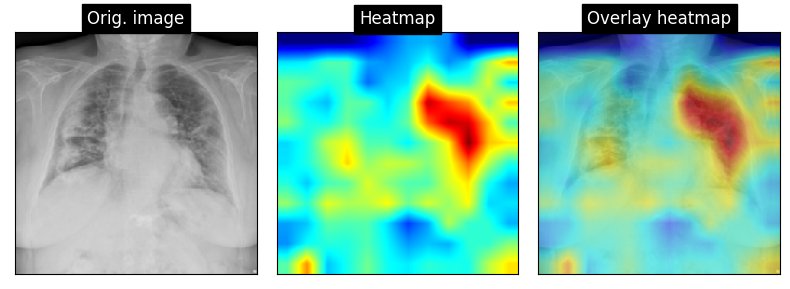

Covid-19 0


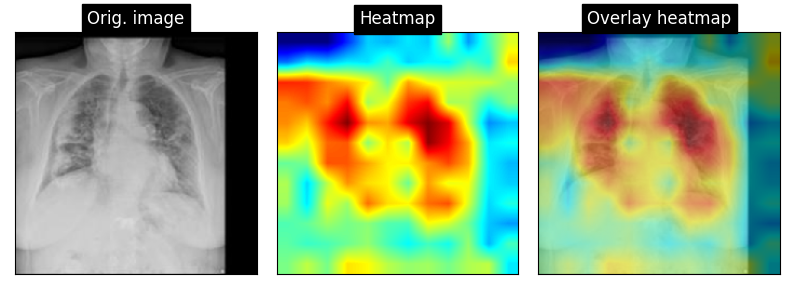

Covid-19 0


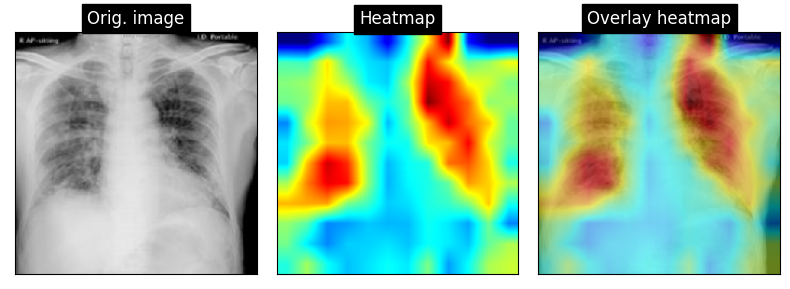

Covid-19 0


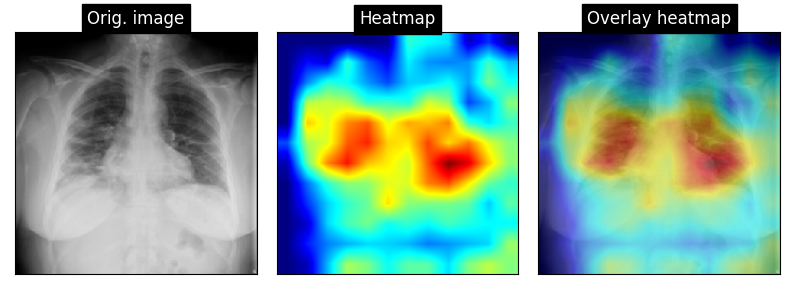

Covid-19 0


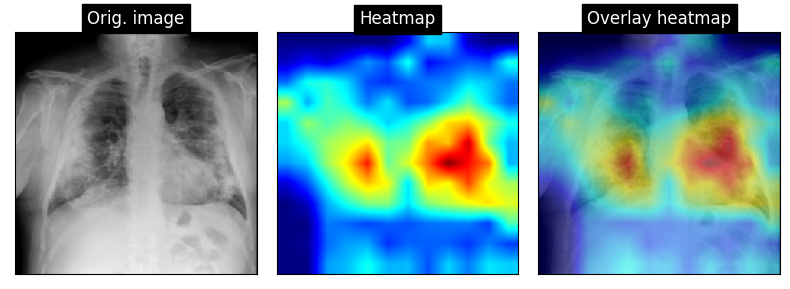

Covid-19 0


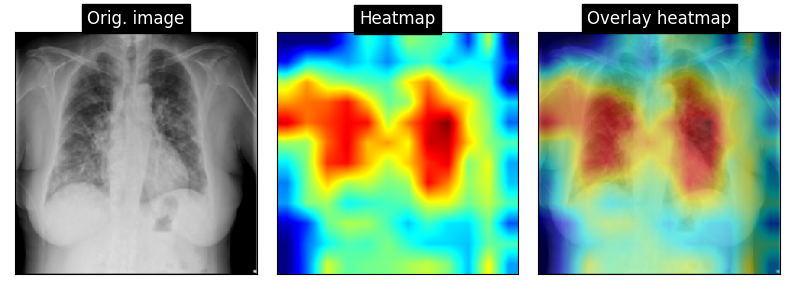

In [27]:

images_path = covids
#images_path = normals
#images_path = pneumonias
for img_path in images_path:
    input_img = preprocess_image(img_path)
    preds = model.predict(input_img)
    lab, index = decode_prediction(preds)
    print(lab, index)
    # initialize our gradient class activation map and build the heatmap
    cam = GradCAM(model, index, 'mixed7')
    heatmap = cam.compute_heatmap(input_img)
    img = np.asarray(load_img(img_path, target_size=(224, 224)))
    (heatmap_out, output) = cam.overlay_heatmap(heatmap, img, alpha=0.5)
    display_imgs([img, heatmap_out, output])
    #plt.title(lab, fontsize='16', backgroundcolor='black', color='white')
    #plt.imshow(heatmap_out)
    #plt.figure()
